## Clutering IMDB Movie Reviews
### DS 7337 - Natural Laguage Processing - Homework 7
#### George C. Sturrock
##### March 30, 2019
##### Homework 7 Objectives
Cluster the reviews that you collected in homework 5, by doing the following:
1.	In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.  

2.	Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact. 

3.	Explain which of the two clustering results from question 1 is preferable (if one of them is), and why. 

##### Resources
http://brandonrose.org/clustering
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

#### Import Libraries

In [1]:
import platform; print("Platform:", platform.platform())
import os
import sys; print("Python:", sys.version)
import requests; print("Requests:", requests.__version__)
from urllib import request; ("urllib:", request.__version__)
import warnings
warnings.filterwarnings('ignore')
from time import sleep

#Web Scraping
import bs4; print("BeatifulSoup:", bs4.__version__)
from bs4 import BeautifulSoup
import json; print("json:", json.__version__)

#Python Basics
import numpy as np; print("Numpy Version:", np.__version__)
import pandas as pd; print("Pandas Version:", pd.__version__)
from matplotlib import pyplot as plt
import seaborn as sns;

#scikit learn
from sklearn import metrics
from sklearn.feature_extraction import stop_words
#print(stop_words.ENGLISH_STOP_WORDS)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#HAC
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering
#KMeans
from sklearn.cluster import KMeans

import pattern; print("Pattern Version:", pattern.__version__)
from pattern.en import tag, parse
from pattern.en import parsetree
from pattern.en import sentiment, positive
from pattern.vector import Document, Model, TFIDF, TF

Platform: Windows-10-10.0.14393-SP0
Python: 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Requests: 2.21.0
BeatifulSoup: 4.7.1
json: 2.0.9
Numpy Version: 1.15.4
Pandas Version: 0.23.0
Pattern Version: 3.6


### Data Acquisition
The first three films in the "Rocky" series will be utilized to collect reviews for noun phrase chunking.  Link to the main user review page for each of the three movies are shown below.  To assure both positive and negative reviews are collected, there are two links per movie.  One is sorted descending by user rating.  The other is sorted ascending by user rating.  Both links have "spoiler alert" messages suppressed as these reviews are often more akin to a summarization of the movie plot instead of a true review.  

In [2]:
#Rocky movie list.  Two links for each movie to assure positive and negative reviews are captured.  
#Sort descending by Review Rating.  Sort ascending by Review Rating.

#Rocky
rockyDict = {"aRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0", 
         "dRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0", 
#Rocky 2
         "dRocky 2":"https://www.imdb.com/title/tt0079817/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 2":"https://www.imdb.com/title/tt0079817/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0",
#Rocky 3
         "dRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0"
            }

rockyKeys = rockyDict.keys()

#### Web Scraping IMDB Movie Review Titles
The individual links to the user reviews are collected below.  A get request uses each of the links in the "rockyDict" python dictionary.  The response is parsed by Beautiful Soup to find the individual links to each individual review.  The review URLs along with the movie name are written to a dataframe named dfRockyReviews.

In [3]:
reviewUrls = list()
dfRockyReviews = pd.DataFrame(columns = ['Movie', 'ReviewURL'])

for r in rockyKeys:
    #print(r, rockyDict[r])
    response = requests.get(rockyDict[r])
    soup = BeautifulSoup(response.text, 'html.parser')
    rUrls = ["http:" + s.attrs['href'] for s in soup.find_all(href = True, class_ = 'title')]
    reviewUrls = reviewUrls + rUrls
    for u in rUrls:
        dfRockyReviews = dfRockyReviews.append({'Movie':r[1:], 'ReviewURL':u}, ignore_index=True)

A sample of the dfRockyReviews dataframe is shown below.

In [4]:
dfRockyReviews[0:5]

,Movie,ReviewURL
0,Rocky,http:/review/rw0149538/?ref_=tt_urv
1,Rocky,http:/review/rw4247059/?ref_=tt_urv
2,Rocky,http:/review/rw0149534/?ref_=tt_urv
3,Rocky,http:/review/rw1979442/?ref_=tt_urv
4,Rocky,http:/review/rw3451942/?ref_=tt_urv


#### Web Scraping IMDB Movie Review Details
The individual review URLs collected above will be requested and parsed to retrieve key qualitative and categorical data about each review along with the review text itself.  These details are stored in a new dataframe named dfReviewDetails.  The first five records are this dataframe are shown below.

In [5]:
dfReviewDetails = pd.DataFrame(columns=['Movie', 'ReviewUrl', 'ReviewDate', 'ReviewTitle', 'Review', 'Rating', 
                                        'Language'])
counter = 0

for r in reviewUrls:
    fullUrl = "https://www.imdb.com" + r[5:]
    response2 = requests.get(fullUrl)
    soup2 = BeautifulSoup(response2.text, 'html.parser')
    rjson = soup2.find('script', type = 'application/ld+json').text
    rjson = json.loads(rjson)
    
    try:
        rating = rjson['reviewRating']['ratingValue']
    except Exception as e:
        #print("No User Rating")
        rating = 5
    
    dfReviewDetails = dfReviewDetails.append({'Movie':dfRockyReviews.Movie[counter], 'ReviewUrl':r, 
                                              'ReviewDate':rjson['dateCreated'], 'ReviewTitle':rjson['name'], 
                                              'Review':rjson['reviewBody'], 'Rating':rating, 
                                              'Language':rjson['inLanguage']}, ignore_index=True)
    counter += 1

dfReviewDetails.head()

,Movie,ReviewUrl,ReviewDate,ReviewTitle,Review,Rating,Language
0,Rocky,http:/review/rw0149538/?ref_=tt_urv,1999-11-25,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,1,English
1,Rocky,http:/review/rw4247059/?ref_=tt_urv,2018-07-21,Rubbish,The fight scenes are pathetic and the acting i...,1,English
2,Rocky,http:/review/rw0149534/?ref_=tt_urv,1998-08-19,overrated piece of cheese,grubby late-night fare achieved way too much s...,2,English
3,Rocky,http:/review/rw1979442/?ref_=tt_urv,2008-11-22,The most overrated movie of all time,I went to see this movie when it came out. I h...,3,English
4,Rocky,http:/review/rw3451942/?ref_=tt_urv,2016-04-15,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,3,English


The bar plot below shows movie review ratings for the reviews collected in the prior step. The original "Rocky" is widely considered the best of the "Rocky" series.  It won multiple Oscars and introduced "Steady-Cam" technology to the movie world.  However, the sample of user reviews collected tell a different story.  

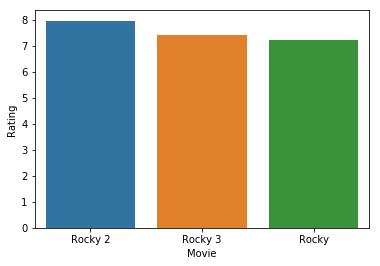

In [6]:
plotdf = dfReviewDetails.sort_values(by=['ReviewDate'])
plotdf.Rating = plotdf.Rating.astype('int64')
plotdf.ReviewDate = pd.to_datetime(plotdf.ReviewDate)
plotdf = plotdf.groupby(['Movie']).mean().reset_index()
sns.barplot(x='Movie', y='Rating', data=plotdf.sort_values(by=['Rating'], ascending=False))

### Question 7.1 - Review Clustering
For this requirement, the IMDB reviews will be clustered using K-Means and Hiearchical Agglomerative Clustering.  The results are presented in the sections below.  The first step is to produce a vectorized matrix the review text.

In [7]:
tfidfVectorizer = TfidfVectorizer(max_df=1, min_df=0, stop_words='english', use_idf=True, ngram_range=(1,3))

tfidfMatrix = tfidfVectorizer.fit_transform(dfReviewDetails.Review)
tfidfMatrix.shape

(150, 28580)

#### KMeans Clustering
The following code chunk determines the optimum combination of clusters, relative tolerance, and method of initialization based on the silhouette score.  The silhouette scores produced by the KMeans algorithm are all negative.  This indicates the clustering algorithm may not have effectively clustered the data.

In [8]:
bestSilScore = -9999999999999
rState = 20190325
tolList = [0.1, 0.01, 0.001, 0.0001]
initList = ['k-means++', 'random']

for i in range(2, 7, 1):
    for t in tolList:
        for n in initList:
            km = KMeans(n_clusters=i, tol=t, init=n, random_state=rState)
            kmFit = km.fit(tfidfMatrix)
            clusters = km.labels_.tolist()
            silScore = metrics.silhouette_score(tfidfMatrix, km.labels_)
            if silScore > bestSilScore:
                print("Clusters: ", i, "| tol:", t, "| Init", n, "| Silhouette Score:", silScore)
                bestSilScore = silScore
                nClust = i
                nTol = t
                nInit = n

Clusters:  2 | tol: 0.1 | Init k-means++ | Silhouette Score: -2.255699498975684e-15
Clusters:  2 | tol: 0.1 | Init random | Silhouette Score: 1.3073636539306852e-15


The optimum combination of KMeans parameters are shown below.

In [9]:
print("Optimum Number of Clusters:", nClust)
print("Optimum tol:", nTol)
print("Optimum Init:", nInit)

Optimum Number of Clusters: 2
Optimum tol: 0.1
Optimum Init: random


The KMeans model is instantiated and fit to the vectorized matrix created from the movie reviews.

In [10]:
km = KMeans(n_clusters=nClust, tol=nTol, init=nInit, random_state=rState)
kmFit = km.fit(tfidfMatrix)
clusters = km.labels_.tolist()

Next, a dictionary with the cluster per observation is assembled.  The dictionary is then converted to a pandas dataframe for processing.

In [11]:
reviewDict = {'cluster': clusters, 'movie': dfReviewDetails.Movie, 'rating': dfReviewDetails.Rating, 'title': dfReviewDetails.ReviewTitle, 
              'review': dfReviewDetails.Review}

In [12]:
dfKmClust = pd.DataFrame.from_dict(reviewDict)
dfKmClust['rating'] = dfKmClust['rating'].astype('int64')
#dfKmClust.head()

To provide additional depth of cluster analysis, the sentiment and polarity score for each review is calculated and attached to the KMeans clustering dataframe.

In [13]:
reviews = dfKmClust['review']
sa = []
pol = []

for r in dfKmClust['review']:
    tmp = sentiment(r)
    sa.append(round(tmp[0], 4))
    pol.append(round(tmp[1], 4))

In [14]:
dfKmClust['sentiment'] = sa
dfKmClust['polarity'] = pol

In [15]:
dfKmClust.head()

,cluster,movie,rating,title,review,sentiment,polarity
0,0,Rocky,1,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,-0.0500,0.3815
1,0,Rocky,1,Rubbish,The fight scenes are pathetic and the acting i...,-0.5000,0.6667
2,0,Rocky,2,overrated piece of cheese,grubby late-night fare achieved way too much s...,0.0757,0.5011
3,0,Rocky,3,The most overrated movie of all time,I went to see this movie when it came out. I h...,0.1389,0.4944
4,0,Rocky,3,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,-0.1371,0.5229


KMeans clustering identified five clusters.  Three of those clusters have one document each. 

0    149
1      1
Name: cluster, dtype: int64


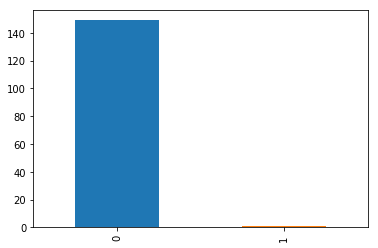

In [16]:
dfKmClust['cluster'].value_counts().plot(kind='bar')
print(dfKmClust['cluster'].value_counts())

##### User Rating
The IMDB user rating shows only a slight difference between clusters 1 and 2. On a ten point scale, the average user rating of Cluster 1 is 0.2 greater than that of Cluster 2.

In [17]:
clusterRate = dfKmClust['rating'].groupby(dfKmClust['cluster'])
print(clusterRate.mean())

cluster
0     7.503356
1    10.000000
Name: rating, dtype: float64


##### Sentiment Analysis
Cluster 2 is slightly more positive than Cluster 1 according to average sentiment analysis scores.

In [18]:
#https://www.clips.uantwerpen.be/pages/pattern-en#sentiment
clusterSent = dfKmClust['sentiment'].groupby(dfKmClust['cluster'])
print(clusterSent.mean())

cluster
0    0.185449
1    0.172300
Name: sentiment, dtype: float64


##### Polarity
As with the other scores, there is only a slight difference between the two primary KMeans clusters.

In [19]:
#https://www.clips.uantwerpen.be/pages/pattern-en#sentiment
clusterPol = dfKmClust['polarity'].groupby(dfKmClust['cluster'])
print(clusterPol.mean())

cluster
0    0.50264
1    0.53900
Name: polarity, dtype: float64


##### Clusters by Movie
Plotting the count of individual movie per cluster reveals a difference between the two major clusters.  Reviews for Rocky 2 are proportionally greater in cluster 2 compared to cluster 1.

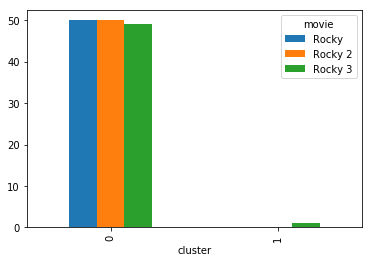

In [20]:
#https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
#https://stackoverflow.com/questions/17679089/pandas-dataframe-groupby-two-columns-and-get-counts/47125795#47125795
clusterMovie = dfKmClust.groupby(['movie', 'cluster']).size().sort_values(ascending=False).reset_index(name='count')
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html#
clusterMovie.pivot(index='cluster', columns='movie', values='count').fillna(0).plot(kind='bar')

##### TFIDF Weighted Features per KMeans Cluster
The top 12 TDIDF weighted features from KMeans clusters 1 and 2 are produced using the Pattern "Document" and "Model" functions.  Clusters 1 and 2 are partitioned into their own dataframes.  Each review is converted to a Pattern Document.  The Documents are appended to one another and transformed into a Model.  The results is a Model for cluster 1 and a Model for cluster 2.  The top 12 features with a TDIDF weighting greater than 0.2 are printed.

In [21]:
dfKmClust1 = dfKmClust[dfKmClust.cluster == 1]
dfKmClust1.reset_index(inplace=True)
dfKmClust2 = dfKmClust[dfKmClust.cluster == 2]
dfKmClust2.reset_index(inplace=True)

In [22]:
#https://www.clips.uantwerpen.be/pages/pattern-vector#model

def clusterFeatures(list):
    docs = []
    for l in range(len(list)):
        docs.append(Document(list[l], type=list[l].strip('"')))
    mb = Model(documents=docs, weight=TFIDF)
    mfs = mb.feature_selection(top=12, threshold=0.2)
    return mb, mfs

In [23]:
mb1, mfs1 = clusterFeatures(dfKmClust1['review'])
mb2, mfs2 = clusterFeatures(dfKmClust2['review'])

Again, Cluster 2 contained a higher proportional count of Rocker 2 reviews compared to Cluster 1.  In Rocky 2, the movie centered around three primary themes:  Rocky's retirement from boxing, the birth of his first and only child and the rematch with Apollo Creed.  Examination of the key features of Cluster 1 and 2 are difficult to distinguish.  Features such as "ii", life and rematch could be tied directly to Rocky 2.  However, the key features are not overwhelmingly postitive or negative in a single cluster.  There is a smattering of character names and actor names in each cluster.  

In [24]:
print("Cluster 1")
print(mfs1)
print()
print("Cluster 2")
print(mfs2)

Cluster 1
['accepts', 'adrian', 'agrees', 'alice', 'angry', 'anymore', 'apollo', 'attack', 'attention', 'beat', 'beating', 'beats']

Cluster 2
[]


#### Hierarchical Clustering
The optimum number of clusters for Hiearchical Agglomerative Clustering are determined and display.  The agglomerative clustering algorithm requires a dense matrix.  So, the vectorized matrix created for KMeans clustering is converted to a dense matrix.  The silhouette scores of the Hierachical Agglomerative Clustering algorithm are negative.  The algorithm struggles with identifying meaningful clusters.

In [25]:
denseTfidf = tfidfMatrix.toarray()

In [26]:
bestSilScore = -999999999999
nClust2 = 0

for i in range(2, 15, 1):
    ac = AgglomerativeClustering(n_clusters=i, linkage='ward')
    acFit = ac.fit(denseTfidf)
    clusters2 = acFit.labels_.tolist()
    silScore = metrics.silhouette_score(denseTfidf, acFit.labels_)
    if silScore > bestSilScore:
        print("Clusters: ", i, "| Silhouette Score:", silScore)
        bestSilScore = silScore
        nClust2 = i

Clusters:  2 | Silhouette Score: 3.2971941632359246e-16


In [27]:
print("Optimum Number of Clusters:", nClust2)

Optimum Number of Clusters: 2


The agglomerative clustering model is instantiated and fit using the dense vectorized matrix of terms.

In [28]:
ac = AgglomerativeClustering(n_clusters=nClust2, linkage='ward')
acFit = ac.fit(denseTfidf)
acFit.labels_
clusters2 = acFit.labels_.tolist()

In [29]:
dfacPlot = dfReviewDetails
dfacPlot['cluster'] = clusters2

The cluster for each document is appended to a dictionary containing the review-wise details.

In [30]:
reviewDict2 = {'cluster': clusters2, 'movie': dfReviewDetails.Movie, 'rating': dfReviewDetails.Rating, 'title': dfReviewDetails.ReviewTitle, 
              'review': dfReviewDetails.Review}

In [31]:
dfHacClust = pd.DataFrame.from_dict(reviewDict2)
dfHacClust['rating'] = dfHacClust['rating'].astype('int64')

As with KMeans clustering, we attach the sentiment and polarity scores for each review to the dataframe.  The average sentiment and polarity will be calculated for these clusters as well to deteremine if this provides evidence of a different between clusters.

In [32]:
dfHacClust['sentiment'] = sa
dfHacClust['polarity'] = pol
dfHacClust.head()

,cluster,movie,rating,title,review,sentiment,polarity
0,0,Rocky,1,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,-0.0500,0.3815
1,0,Rocky,1,Rubbish,The fight scenes are pathetic and the acting i...,-0.5000,0.6667
2,1,Rocky,2,overrated piece of cheese,grubby late-night fare achieved way too much s...,0.0757,0.5011
3,0,Rocky,3,The most overrated movie of all time,I went to see this movie when it came out. I h...,0.1389,0.4944
4,1,Rocky,3,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,-0.1371,0.5229


##### HAC Cluster Counts
Cluster 0 and 1 are the primary clusters identified by hierarchical agglomerative clustering.  However, there are eight single document clusters.  

1    107
0     43
Name: cluster, dtype: int64


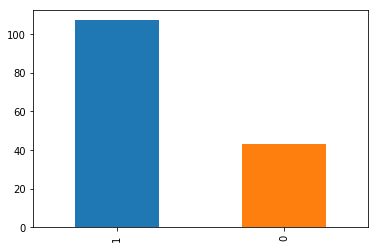

In [33]:
dfHacClust['cluster'].value_counts().plot(kind='bar')
print(dfHacClust['cluster'].value_counts())

##### Sentiment Analysis HAC

In [34]:
clusterSent2 = dfHacClust['sentiment'].groupby(dfHacClust['cluster'])
print(clusterSent2.mean())

cluster
0    0.156321
1    0.197032
Name: sentiment, dtype: float64


##### Polarity Analysis HAC

In [35]:
clusterPol2 = dfHacClust['polarity'].groupby(dfHacClust['cluster'])
print(clusterPol2.mean())

cluster
0    0.481965
1    0.511289
Name: polarity, dtype: float64


##### HAC Movies per Cluster
As with the KMeans clustering results, the primary observable difference between clusters is the ratio of movies.  The ranking of highest to lowest movies for Cluster 0 is Rocky, Rocky 2, and Rocky 3.  The rankings for Cluster 1 are reversed.  

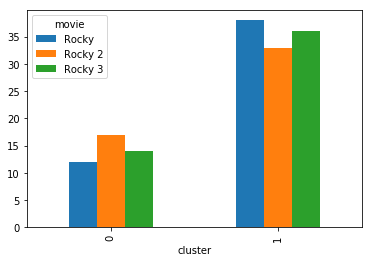

In [36]:
clusterMovie2 = dfHacClust.groupby(['movie', 'cluster']).size().sort_values(ascending=False).reset_index(name='count')
clusterMovie2.pivot(index='cluster', columns='movie', values='count').fillna(0).plot(kind='bar')

##### TFIDF Weighted Features per HAC Cluster
Cluster 0 is high on Rocky and low on Rocky 3 documents.  Cluster 1 is high on Rocky 3 and low on Rocky documents.  Again, there is no discernable difference in sentiment between the key features of the two primary clusters.  Cluster 1 does show Rocky 3 specific tokens of "iii" and "clubber".  Rocky's trainer "Mickey", played by Burgess Meredith also dies in Rocky 3.  The key features are very similar to those identified by KMeans clustering.  The same Pattern based method used for KMeans is called for the Hierarchical Agglomerative Clustering clusters.

In [37]:
dfHacClust0 = dfHacClust[dfHacClust.cluster == 0]
dfHacClust0.reset_index(inplace=True)
dfHacClust1 = dfHacClust[dfHacClust.cluster == 1]
dfHacClust1.reset_index(inplace=True)

In [38]:
mb1a, mfs1a = clusterFeatures(dfHacClust0['review'])
mb2a, mfs2a = clusterFeatures(dfHacClust1['review'])

In [39]:
print("Cluster 0")
print(mfs1a)
print()
print("Cluster 1")
print(mfs2a)

Cluster 0
['rocky', 'character', 'clubber', 'ring', 'scenes', 'wife', 'acting', 'balboa', 'burgess', 'champion', 'iii', 'meredith']

Cluster 1
['rocky', 'balboa', 'weathers', 'carl', 'love', 'series', 'training', 'adrian', 'character', 'movies', 'sylvester', 'boxing']


### Question 7.2
Semantically, there is little difference between the features identified by KMeans and Hierachical Agglomerative Clustering.  It essentially the same set of characters, actors and descriptive tokens.  As described above, the primary difference is in the composition of movies per major cluster.  Possible explanations include the recylcing of plot and characters between the first three Rocky movies.  The primary characters were exactly the same in Rocky and Rocky2.  Only the addition of Mr. T's character in Rocky 3 differentiates the cast.  It is a bit surprising semantic differences from the original Rocky were not identified.  The beginning of the relationship between Rocky and Adrian, and the unique conversations between Rocky and Pauly did not stand out.  The user reviews make little mention of these.  Any review marked as a "spoiler alert" was filtered out of the results processed by the web scraping procedure.  It's possible these reviews could contain unique features.  However, the TF and TFIDF scores show there is little similarity structurally between the top features identified by Hierarchical Agglomerative Clustering.  

In [46]:
d172 = Document(mfs1a)
d272 = Document(mfs2a)
mb72 = Model(documents=[d172, d272], weight=TF)
print("TF Cosine Similarity", round(mb72.similarity(d172, d272),4))
mb72 = Model(documents=[d172, d272], weight=TFIDF)
print("TFIDF Cosine Similarity", mb72.similarity(d172, d272))

TF Cosine Similarity 0.25
TFIDF Cosine Similarity 0.0


### Question 7.3
Given the similarities in key features, sentiment, and polarity between the major clusters produced by KMeans and Hierarchical Agglomerative Clustering, the number of outlier clusters identified by the two algorithms is the deciding factor between algorithms.  Hierarchical Agglomerative Clustering shows eight one document clusters using the optimal model identified above.  Whereas, KMeans found two major clusters and only three one document clusters.  Fewer one document clusters lead to the KMeans model being preferable for this dataset.  However, more algorithms should be tested given the low silouhette scores of both KMeans and Hierarchical Agglomerative Clustering.

### Code Appendix

In [61]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
#plt.figure(figsize=(50,50))
#children = acFit.children_
#distance = np.arange(children.shape[0])
#no_of_observations = np.arange(2, children.shape[0]+2)
#linkageMatrix = np.column_stack([children, distance, no_of_observations]).astype(float)
#
#dn = dendrogram(linkageMatrix, labels=dfReviewDetails.index, p=30, truncate_mode='level', orientation='right', show_leaf_counts=True, leaf_font_size = 9)
#dn = dendrogram(linkageMatrix, labels=dfReviewDetails.index, show_leaf_counts=False, orientation='right', leaf_font_size=10)
#
#plt.show()

In [60]:
#viz = InterclusterDistance(km)
#viz.fit(tfidfMatrix)
#viz.poof()